# Préparation et traitement de données pour l'usage des données accidents pour l'aménagement cyclable

## Quelques éléments de documentation
La base de données est divisées en 4 parties, qui sont spécialisées : caractéristiques de l'accident, les usagers, les véhicules et les lieux. Les trois dernières tables référencent un identifiant unique dans la première, qui va contenir la géométrie du lieu de l'accident. En outre, les données sont "fraîches" et n'ont donc pas encore fait l'objet de correction. En cas de soucis, on peut contacter le fournisseur pour correction. La base lieux va nous permettre de retrouver tous les accidents ayant eu lieu à proximité d'une voie cyclable.

**vehicule** : contient des informations relatives aux véhicules mêlées aux accidents.  
**caracteristiques** : des informations de localisation et de caractéristiques générales (météo, sol, etc).  
**usagers** :  
**lieux** : les caractéristiques des lieux de l'accident.

## Objectifs :
- Comment télécharger des données massivement depuis le web ?
- Où sont localisées les accidents près des pistes cyclables ?
- Quelles sont les caractéristiques de ces accidents ?
- Localiser les accidents qui impliquent des cyclistes.
- Localiser les accidents près de voies cyclables.
- Existe-t-il des tendances ?

## Importer les données

In [1]:
## Importer des données web 
import requests

## Manipuler les données
import pandas
import geopandas
import os

## Traitement
import numpy
import shapely
import scipy.stats
import datetime

## Représentation
import matplotlib.pyplot as plt
import seaborn
import contextily

## Valoriser les données
import folium

!pip freeze > requirements_cyclo.txt

## 1. Importer les données

In [2]:
## Données de travail 
acc_caract = pandas.read_csv(".\\DONNEES\\carcteristiques-2021.csv",  encoding="utf-8", sep=";", decimal=".")
acc_usagers = pandas.read_csv(".\\DONNEES\\usagers-2021.csv", encoding="utf-8", sep=";", decimal=".")

### 1.1 Table caracteristiques-2021
On va faire là des corrections et une inspection des données. On va également récupérer uniquement les données du 94.

In [3]:
acc_caract.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202100000001,30,11,2021,07:32,2,30,30319,1,1,1,1,CD 981,"44,0389580000","4,3480220000"
1,202100000002,25,9,2021,14:20,1,51,51544,1,3,1,3,Aire de repos croisement D20E9 après sortie D977,"49,2421290000","4,5545460000"
2,202100000003,15,7,2021,07:55,1,85,85048,2,1,7,6,15 rue François Nicolas,"46,9219500000","-0,9644600000"
3,202100000004,27,3,2021,19:45,5,93,93005,2,2,3,6,Route de Mitry,"48,9493634583","2,5196639908"
4,202100000005,25,2,2021,07:20,5,76,76429,2,1,1,2,PARIS. ROUTE DE,"49,4083800000","1,1458100000"


Table des caractéristiques de l'accident. On a un id, on peut construire un datetime. Les données concernent la France entière. Il faudra donc récupérer uniquement les données du 94 :

In [4]:
acc_caract = acc_caract[ acc_caract["dep"] == "94" ]

## On a également des erreurs de type ... On va corriger ça :
acc_caract["jour"] = acc_caract["jour"].astype(str)
acc_caract["mois"] = acc_caract["mois"].astype(str)
acc_caract["an"] = acc_caract["an"].astype(str)

acc_caract["lum"] = acc_caract["lum"].astype(str)
acc_caract["agg"] = acc_caract["agg"].astype(str)
acc_caract["int"] = acc_caract["int"].astype(str)
acc_caract["atm"] = acc_caract["atm"].astype(str)
acc_caract["col"] = acc_caract["col"].astype(str)

## Il est important de changer les types pour les représentations graphiques 
##+ et les analyses par la suite.

acc_caract.dtypes ## OK le type a été changé.

Num_Acc     int64
jour       object
mois       object
an         object
hrmn       object
lum        object
dep        object
com        object
agg        object
int        object
atm        object
col        object
adr        object
lat        object
long       object
dtype: object

In [5]:
acc_caract["dep"].unique() ## pour vérifier qu'on a uniquement le 94.

array(['94'], dtype=object)

Dans la table des caractéristiques, on va créer un datetime. Il va nous servir à localiser l'information dans le temps. Pour ça, on s'appuie sur le module datetime, qui permet de passer de str à un type temps, traitable par Python.

In [6]:
## Créer le datetime :
acc_caract["datetime"] = ""
for i, r in acc_caract.iterrows() :
    ## séparer la date et l'heure :
    h = r["hrmn"].split(":")[0] ## récupérer l'heure
    mn = r["hrmn"].split(":")[1] ## récupérer les minutes
    
    dtm = f"{r['jour']}/{r['mois']}/{r['an']} {h}:{mn}" ## puis assembler pour créer un objet datetime
    res = datetime.datetime.strptime(dtm, "%d/%m/%Y %H:%M") ## créer un objet datetime
    
    ## ajouter le résultat au df à la ligne correspondante :
    acc_caract.loc[i, "datetime"] = res

### 1.1.1 Conclusion sur les données caractéristiques
A ce stade, on a juste la possibilité d'avoir des datetimes. On peut rien lineplot, mais on peut faire une carte. On s'intéresse aux données vélos, donc on va devoir récupérer uniquement les données qui concernent les accidents de vélos. Pour ça, il nous faut d'abord récupérer les accidents qui concernent les vélos (plus pertinent), puis les données qui indiquent des accidents près de voies cyclables.

## 2. Comment télécharger des données massivement depuis le web ?

## 3. Où sont localisées les accidents près des pistes cyclables ?

### 3.1 Récupérer les accidents impliquants des cyclistes
On cherche à récupérer les accidents ayant eu lieu à GPSEA uniquement.

In [7]:
acc_vehicules = pandas.read_csv(".\\DONNEES\\vehicules-2021.csv", sep=";", decimal=".", encoding="utf-8")
acc_vehicules.head()

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202100000001,201 764,B01,1,1,0,2,1,1,5,NaN
1,202100000001,201 765,A01,1,7,0,9,3,17,1,NaN
2,202100000002,201 762,A01,0,7,2,2,1,1,0,NaN
3,202100000002,201 763,B01,0,7,0,2,1,9,0,NaN
4,202100000003,201 761,A01,1,7,0,1,3,1,1,NaN


Cette table informe sur le type de véhicule impliqué dans l'accident. Selon la documentation, la variable catv indique, par un code référencé dans la doc, le type de véhicule.

In [8]:
acc_vehicules.dtypes ## OK pour le champ de jointure
## En revanche, on a un soucis sur le type de variables 

Num_Acc          int64
id_vehicule     object
num_veh         object
senc             int64
catv             int64
obs              int64
obsm             int64
choc             int64
manv             int64
motor            int64
occutc         float64
dtype: object

In [9]:
## on va donc convertir :
acc_vehicules["senc"] = acc_vehicules["senc"].astype(str)
acc_vehicules["catv"] = acc_vehicules["catv"].astype(str)
acc_vehicules["obs"] = acc_vehicules["obs"].astype(str)
acc_vehicules["obsm"] = acc_vehicules["obsm"].astype(str)
acc_vehicules["choc"] = acc_vehicules["choc"].astype(str)
acc_vehicules["manv"] = acc_vehicules["manv"].astype(str)

acc_vehicules.dtypes

Num_Acc          int64
id_vehicule     object
num_veh         object
senc            object
catv            object
obs             object
obsm            object
choc            object
manv            object
motor            int64
occutc         float64
dtype: object

In [10]:
## Ensuite on va récupérer uniquement les cas de vélos (1), autre (99) et inconnus (0)
categ_oi = ["0", "1", "99"] ## catégories d'intérêt
acc_vehicules = acc_vehicules[ acc_vehicules["catv"].isin(categ_oi) ]
acc_vehicules["catv"].unique() ## OK

## combien d'accidents ?
acc_vehicules.shape ## 6275 pour la France entière

(6275, 11)

#### Ensuite, joindre à la table des caractéristiques du 94 :

In [11]:
## Les types de jointure : https://datascientest.com/tout-comprendre-des-jointures-sql

In [11]:
insee_gpsea = ["94002", "94028", "94011", "94044", 
               "94019", "94055", "94053", "94071", 
               "94004", "94075", "94048", "94047",
               "94056", "94070", "94060", "94059"]

In [12]:
acc_caract = acc_caract[ acc_caract["com"].isin(insee_gpsea) ]
acc_caract

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,datetime
394,202100000395,21,10,2021,01:20,5,94,94011,2,9,2,6,Avenue de Verdun,"48,7695000000","2,4826600000",2021-10-21 01:20:00
788,202100000789,29,12,2021,10:20,1,94,94028,2,9,2,1,Avenue Laferrière,"48,8001500000","2,4558100000",2021-12-29 10:20:00
1068,202100001069,28,12,2021,09:45,1,94,94028,2,1,2,6,Avenue Jean-Baptiste Champeval,"48,7950900000","2,4560600000",2021-12-28 09:45:00
1382,202100001383,24,12,2021,12:45,1,94,94028,2,1,8,3,VERDUN.(AVENUE DE),"48,7977800000","2,4643800000",2021-12-24 12:45:00
1506,202100001507,23,12,2021,18:00,5,94,94044,2,1,1,6,Avenue Charles de Gaulle,"48,7513693649","2,5005269051",2021-12-23 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56076,202100056077,6,1,2021,06:30,5,94,94011,2,1,1,3,RHIN ET DANUBE(RUE DU),"48,7728700000","2,4905900000",2021-01-06 06:30:00
56077,202100056078,5,1,2021,09:20,5,94,94028,2,1,1,3,BROSSOLETTE(AVENUE PIERRE),"48,7912300000","2,4626100000",2021-01-05 09:20:00
56346,202100056347,3,1,2021,19:00,5,94,94053,2,1,2,6,PIERRE BROSSOLETTE (R),"48,7762900000","2,5461100000",2021-01-03 19:00:00
56428,202100056429,1,1,2021,09:45,1,94,94011,2,1,4,2,Rue Pierre Sémard,"48,7633050000","2,4799890000",2021-01-01 09:45:00


In [13]:
acc_vehicules.dtypes

Num_Acc          int64
id_vehicule     object
num_veh         object
senc            object
catv            object
obs             object
obsm            object
choc            object
manv            object
motor            int64
occutc         float64
dtype: object

In [14]:
acc_velos = pandas.merge(left=acc_caract, right=acc_vehicules, 
                         left_on="Num_Acc", right_on="Num_Acc", 
                         how="inner")

In [15]:
acc_velos.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202100001508,22,12,2021,13:05,1,94,94002,2,2,...,199 097,Z01,1,0,0,2,1,26,1,NaN
1,202100002052,19,12,2021,16:40,1,94,94002,2,2,...,198 126,A01,1,1,0,2,1,1,5,NaN
2,202100002476,17,12,2021,06:50,5,94,94002,2,4,...,197 344,A01,1,1,0,2,1,2,5,NaN
3,202100010746,26,10,2021,20:15,5,94,94011,2,9,...,182 520,B01,1,1,0,2,0,1,5,NaN
4,202100011432,23,10,2021,01:45,5,94,94011,2,9,...,181 289,B01,2,1,0,2,1,1,5,NaN


#### Nombre d'accident sur le territoire

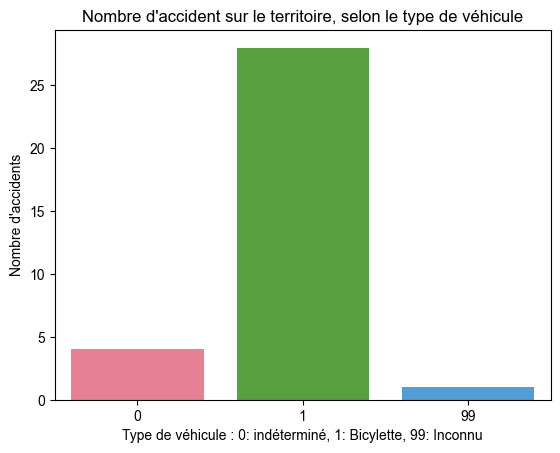

In [16]:
seaborn.countplot(x=acc_velos["catv"], palette="husl")
seaborn.set_style('whitegrid')
plt.title("Nombre d'accident sur le territoire, selon le type de véhicule")
plt.xlabel("Type de véhicule : 0: indéterminé, 1: Bicylette, 99: Inconnu")
plt.ylabel("Nombre d'accidents")
plt.show()

In [17]:
acc_velos.dtypes

Num_Acc          int64
jour            object
mois            object
an              object
hrmn            object
lum             object
dep             object
com             object
agg             object
int             object
atm             object
col             object
adr             object
lat             object
long            object
datetime        object
id_vehicule     object
num_veh         object
senc            object
catv            object
obs             object
obsm            object
choc            object
manv            object
motor            int64
occutc         float64
dtype: object

#### Nombre d'accident par commune

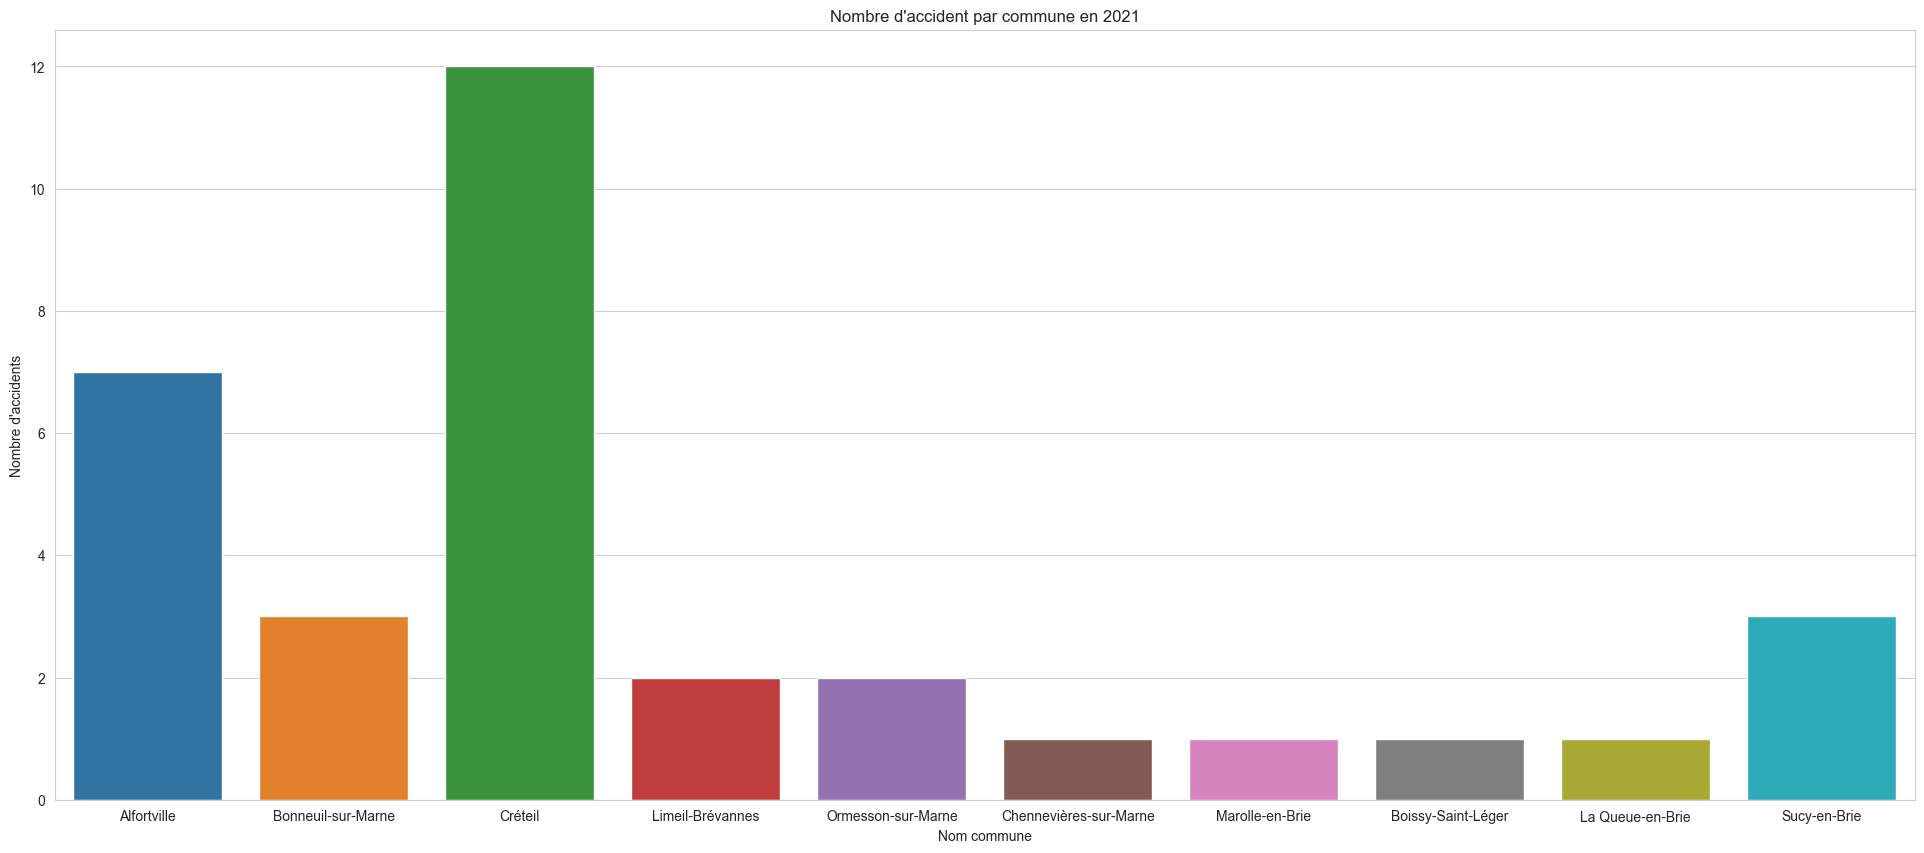

In [18]:
plt.figure(figsize=(24, 10), dpi=100)
seaborn.countplot(data=acc_velos,
                 x="com")
## récupérer les étiquettes de l'axe x :
ax = plt.gca()

# Changer les labels de l'axe x
ax.set_xticklabels(["Alfortville", "Bonneuil-sur-Marne", "Créteil", "Limeil-Brévannes",
                   "Ormesson-sur-Marne", "Chennevières-sur-Marne", "Marolle-en-Brie",
                   "Boissy-Saint-Léger", "La Queue-en-Brie", "Sucy-en-Brie"])

plt.title("Nombre d'accident par commune en 2021")
plt.xlabel("Nom commune")
plt.ylabel("Nombre d'accidents")

plt.show()

#### Variation du nombre d'accident au cours de l'année pour chaque commune

In [19]:
acc_velos.index = list(range(0, acc_velos.shape[0]))
acc_velos["nb_acc"] = 1
acc_velos.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc,nb_acc
0,202100001508,22,12,2021,13:05,1,94,94002,2,2,...,Z01,1,0,0,2,1,26,1,NaN,1
1,202100002052,19,12,2021,16:40,1,94,94002,2,2,...,A01,1,1,0,2,1,1,5,NaN,1
2,202100002476,17,12,2021,06:50,5,94,94002,2,4,...,A01,1,1,0,2,1,2,5,NaN,1
3,202100010746,26,10,2021,20:15,5,94,94011,2,9,...,B01,1,1,0,2,0,1,5,NaN,1
4,202100011432,23,10,2021,01:45,5,94,94011,2,9,...,B01,2,1,0,2,1,1,5,NaN,1


In [20]:
 ## Puis on peut faire un group by et sommer :
temp = acc_velos[ ["com", "nb_acc", "mois"] ]
temp = temp.groupby(by=["com", "mois"])["nb_acc"].sum().reset_index()

temp.head() ## là c'est une série.

,com,mois,nb_acc
0,94002,12,3
1,94002,3,2
2,94002,5,1
3,94002,8,1
4,94004,9,1


In [21]:
## Ensuite on peut afficher le lineplot :
temp["mois"] = temp["mois"].astype(int)
temp = temp.sort_values(by="mois", ascending=True)
temp.dtypes

com       object
mois       int32
nb_acc     int64
dtype: object

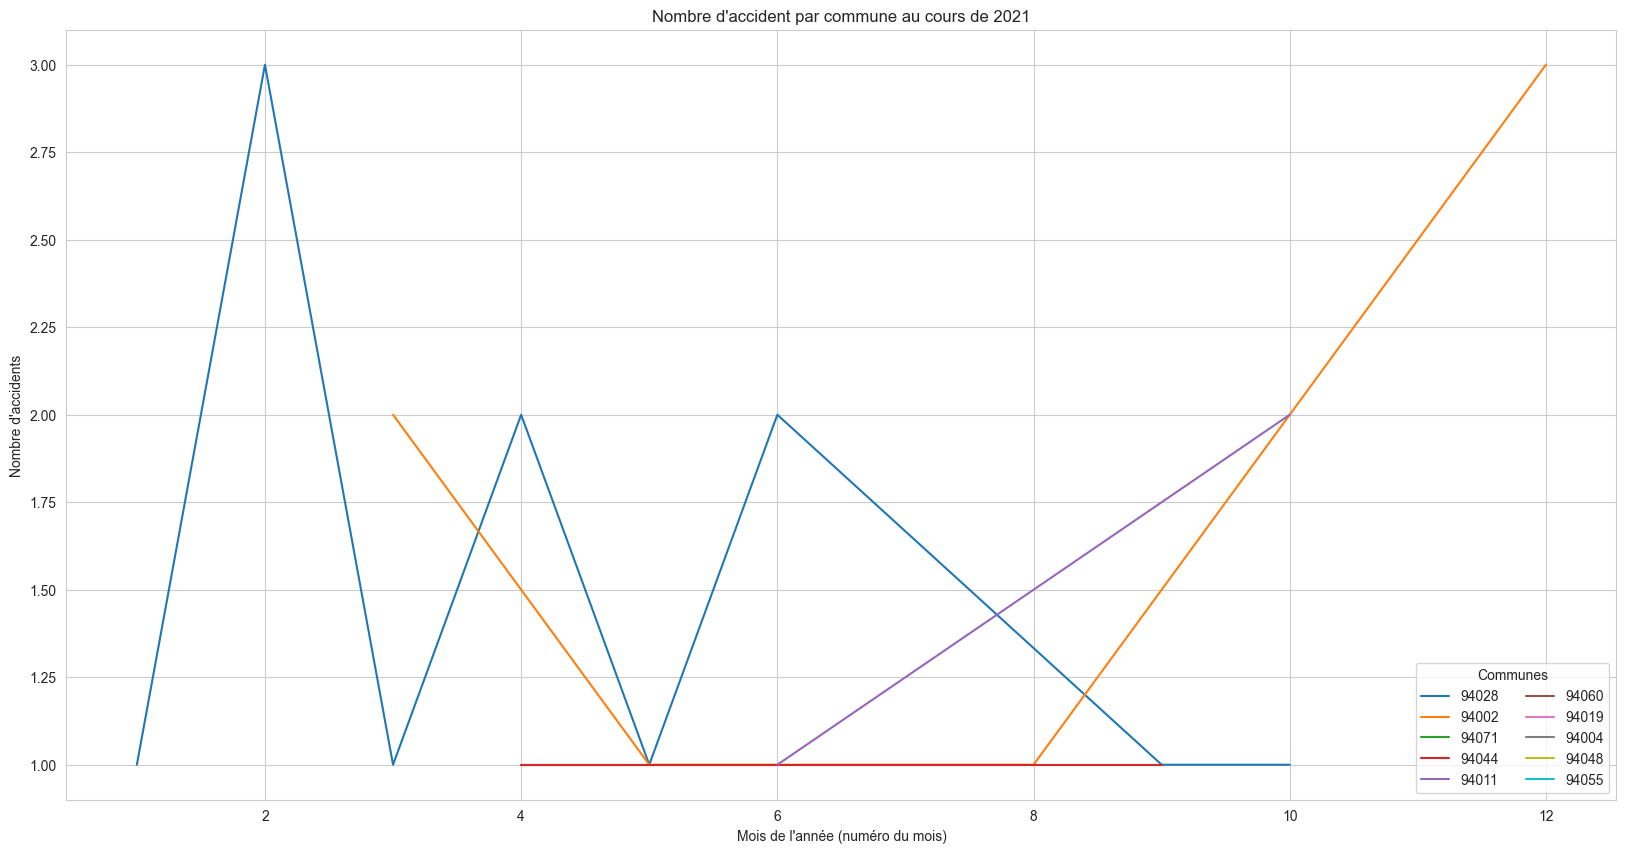

In [22]:
plt.figure(figsize=(20, 10), dpi=100)

acc_trends = seaborn.lineplot(data=temp, x="mois", y="nb_acc", hue="com")
## Replacer la légende :
seaborn.move_legend(obj=acc_trends, 
                    loc="lower right",
                    ncols=2,
                    title="Communes")


plt.title("Nombre d'accident par commune au cours de 2021")
plt.xlabel("Mois de l'année (numéro du mois)")
plt.ylabel("Nombre d'accidents")

## source pour l'association des codes INSEE avec les codes insee : https://fr.wikipedia.org/wiki/%C3%89tablissement_public_territorial_Grand_Paris_Sud_Est_Avenir
plt.show()

Nombre d'accident de vélos par commune au cours de 2021. On peut voir qu'aucun comportement commun ne se dégage. On voit également que Créteil dépasse les autres communes, notamment au mois de février. A Alfortville, le nombre d'accident est plus variable : entre mai et août, ils sont très faibles, alors qu'ils augmentent brutalement après août.  
On peut se questionner alors sur les habitudes de pratique du vélo dans les communes.

### Cartographier les résultats

In [23]:
## Importer les couches d'habillage :
gpsea = geopandas.read_file(".\\DONNEES\\contours_gpsea.geojson", encoding="utf-8")
am_cyclables = geopandas.read_file(".\\DONNEES\\amenagement_cyclable_gpsea.geojson", encoding="utf-8")
voirie_gpsea = geopandas.read_file(".\\DONNEES\\voirie_gpsea.geojson", encoding="utf-8")
occ_sol = geopandas.read_file(".\\DONNEES\\occuptation_du_sol.geojson")

In [24]:
acc_velos.columns ## On n'a pas de géométrie !

Index(['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg',
       'int', 'atm', 'col', 'adr', 'lat', 'long', 'datetime', 'id_vehicule',
       'num_veh', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'occutc', 'nb_acc'],
      dtype='object')

<Axes: >

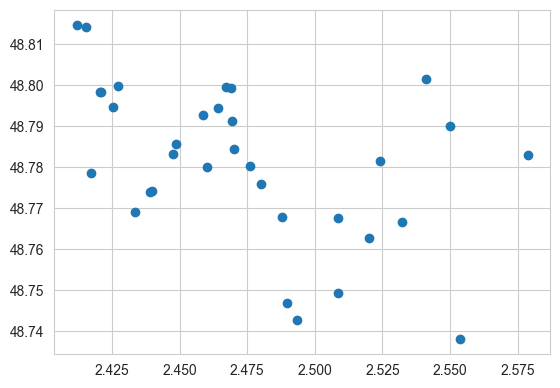

In [29]:
acc_velos['long'] = acc_velos['long'].str.replace(",", ".")
acc_velos['lat'] = acc_velos['lat'].str.replace(",", ".")

acc_velos["geo"] = geopandas.points_from_xy(x=acc_velos["long"], y=acc_velos["lat"], crs="EPSG:4326")
acc_velos = geopandas.GeoDataFrame(acc_velos, geometry="geo")

## Et si la vie est bien faite ...
acc_velos.plot()

In [26]:
gpsea = gpsea.to_crs(crs="3949")
am_cyclables = am_cyclables.to_crs(crs="3949")
voirie_gpsea = voirie_gpsea.to_crs(crs="3949")
acc_velos = acc_velos.to_crs(crs="3949")
occ_sol = occ_sol.to_crs(crs="4326")

AttributeError: 'DataFrame' object has no attribute 'to_crs'

In [126]:
occ_sol = occ_sol.to_crs(crs="4326")

In [119]:
acc_velos = acc_velos.to_crs(crs="4326")

In [61]:
## A la naissance les POINT geopandas, sans précision, n'ont pas CRS.
## Il faut donc en attribuer un :
acc_velos["geometry"] = acc_velos["geometry"].set_crs(epsg=4326)

## Ensuite, il faut créer un nouveau champ qui va contenir la géométrie reprojetée en 3949 :
acc_velos["geomLam93"] = acc_velos["geometry"].to_crs(epsg=3949)

acc_velos.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,catv,obs,obsm,choc,manv,motor,occutc,nb_acc,geometry,geomLam93
0,202100001508,22,12,2021,13:05,1,94,94002,2,2,...,0,0,2,1,26,1,NaN,1,POINT (2.42708 48.79984),POINT (1657914.424 8177901.309)
1,202100002052,19,12,2021,16:40,1,94,94002,2,2,...,1,0,2,1,1,5,NaN,1,POINT (2.42079 48.79825),POINT (1657451.033 8177728.017)
2,202100002476,17,12,2021,06:50,5,94,94002,2,4,...,1,0,2,1,2,5,NaN,1,POINT (2.41725 48.77855),POINT (1657174.173 8175539.493)
3,202100010746,26,10,2021,20:15,5,94,94011,2,9,...,1,0,2,0,1,5,NaN,1,POINT (2.48022 48.77579),POINT (1661799.683 8175199.104)
4,202100011432,23,10,2021,01:45,5,94,94011,2,9,...,1,0,2,1,1,5,NaN,1,POINT (2.48778 48.76797),POINT (1662349.344 8174325.678)


In [71]:
import contextily ## module pour mettre un fond de carte

In [132]:
ax.plot?

<Figure size 7000x1000 with 0 Axes>

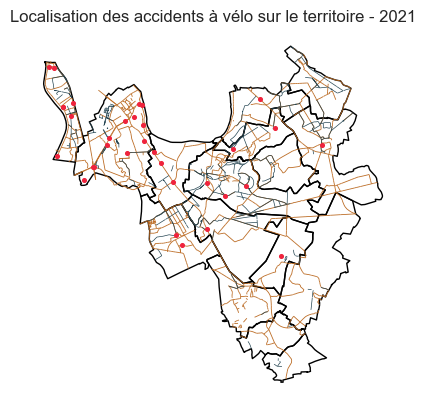

In [138]:
## Puis ploter :
plt.figure(figsize=(70, 10), dpi=100)

base = gpsea.plot(color="#00000000", edgecolor="black")
base = am_cyclables.plot(ax=base, edgecolor="#bc6c25", linewidth=0.6)
base = voirie_gpsea.plot(ax=base, edgecolor="#264653", linewidth=0.5)
acc_velos.plot(ax=base, color="#ef233c", markersize=7, zorder=99)

## ajouter un fond de carte :
## contextily.add_basemap(ax=base, crs=acc_velos.crs.to_string(), source=contextily.providers.OpenStreetMap.Mapnik)

plt.title("Localisation des accidents à vélo sur le territoire - 2021")
plt.axis("off")
plt.show()

#### Qu'est-ce qu'on vient de faire ?

In [34]:
acc_velos.columns

## conserver :
temp = acc_velos[ ['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg',
       'int', 'atm', 'col', 'adr', 'id_vehicule',
       'num_veh', 'senc', 'catv', 'nb_acc', 'geo'] ]

In [35]:
temp.to_file(".\\RESULTATS\\accidents_velos_gpsea.shp")

C:\Users\will\AppData\Local\Temp\ipykernel_117212\3810357685.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  temp.to_file(".\\RESULTATS\\accidents_velos_gpsea.shp")


## Quelles sont les caractéristiques de ces accidents ?